In [1]:
import matplotlib.pyplot as plt
from utils.operators import top_k_op, hosvd_compression_op, tucker_compression_op
from utils.train import run_training
from utils.graphs import plot_training_results

compression_operators = {
    #'TopK': top_k_op(k=5),
    'Tucker' : tucker_compression_op(),
    # 'HOSVD': hosvd_compression_op(),
    'Id': lambda x: x,
}

num_epochs = 4

In [2]:
for name, op in compression_operators.items():
    run_training(
        compression_op_name=name, 
        compression_op=op, 
        num_epochs=num_epochs,
        device='cuda'
    )

Files already downloaded and verified
Starting epoch 3 with Tucker
Starting epoch 4 with Tucker
Starting epoch 5 with Tucker
Starting epoch 6 with Tucker
Files already downloaded and verified
Starting epoch 3 with Id
Starting epoch 4 with Id
Starting epoch 5 with Id
Starting epoch 6 with Id


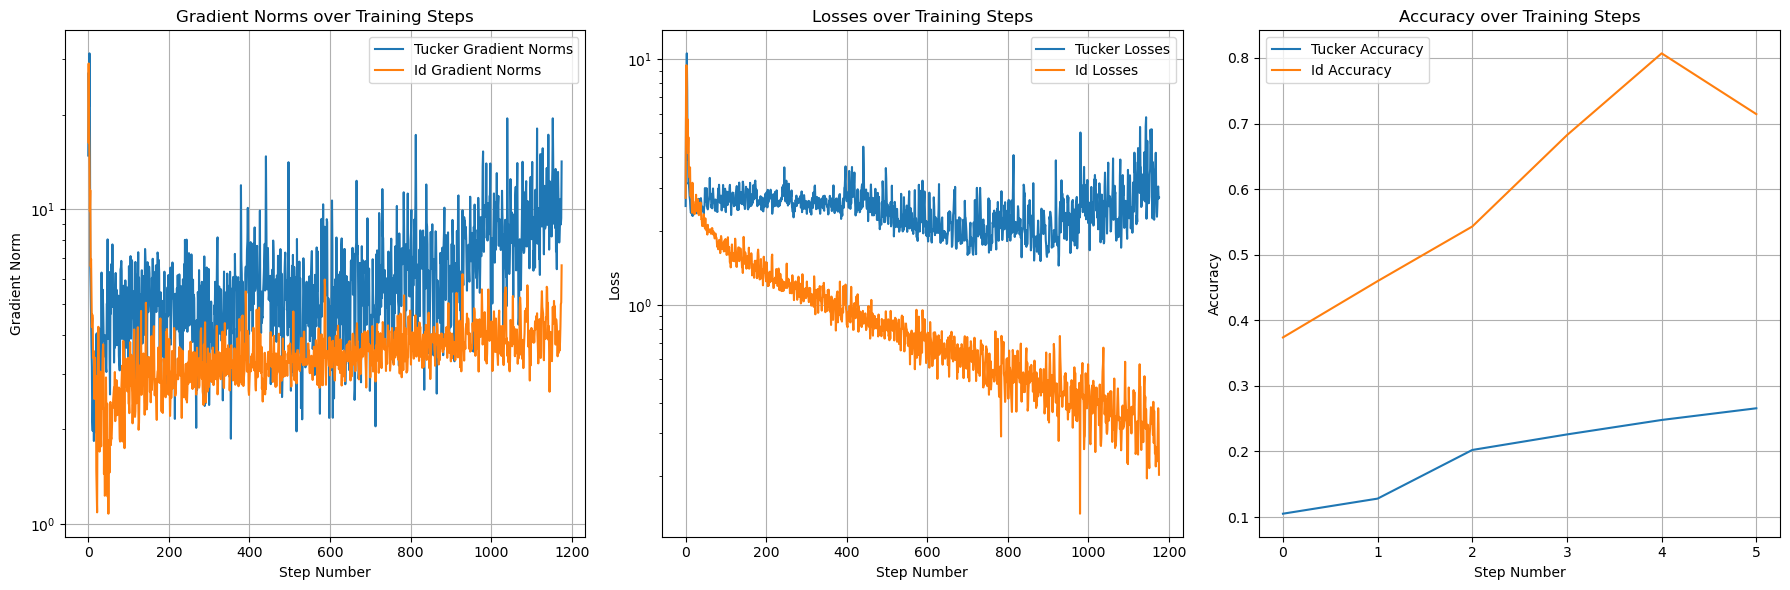

In [3]:
plot_training_results(compression_operators)